In [100]:
# Let's try with sympy

import numpy as np
import sympy
embedding_dim = 2
hidden_dim = 3

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

def expr_to_string(expr):
    return str(round_expr(expr, 2)).replace("Max(0, ", "ReLU(")

def random_matr(*shape):
    return sympy.Matrix(np.random.normal(size=shape))

A     = random_matr(hidden_dim, 2 * embedding_dim)
A_hat = random_matr(*A.shape)
b     = random_matr(hidden_dim, 1)
b_hat = random_matr(*b.shape)
C     = random_matr(hidden_dim, hidden_dim)
C_hat = random_matr(*C.shape)
d     = random_matr(hidden_dim, 1)
d_hat = random_matr(*d.shape)
E     = random_matr(1, hidden_dim)
E_hat = random_matr(*E.shape)
f     = random_matr(1, 1)
f_hat = random_matr(*f.shape)

beta = sympy.Symbol("β", real=True)

class relu(sympy.Function):
    @classmethod
    def eval(cls, x):
        return x.applyfunc(lambda elem: sympy.Max(elem, 0))

    def _eval_is_real(self):
        return True

delta_e1 = np.random.normal(size=(2 * embedding_dim, 1))
delta_e2 = np.random.normal(size=(2 * embedding_dim, 1))
# the first half of the vectors is always the same
delta_e2[:embedding_dim, :] = delta_e1[:embedding_dim, :]
delta_e1 = sympy.Matrix(delta_e1)
delta_e2 = sympy.Matrix(delta_e2)

def q(beta, x):
    result = relu((A + beta * A_hat) @ x + b + beta * b_hat)
    result = relu((C + beta * C_hat) @ result + d + beta * d_hat)
    result = (E + beta * E_hat) @ result + f + beta * f_hat
    return result

def to_scalar(x):
    assert x.shape == (1, 1)
    return x[0, 0]
    
logit = to_scalar(q(beta, delta_e1) - q(beta, delta_e2))
print(expr_to_string(logit))
dlogit_dbeta = logit.diff(beta)
print(expr_to_string(dlogit_dbeta))

(0.42 - 0.28*β)*ReLU(2.72*β + (-1.83*β - 1.0)*ReLU(-1.39*β - 0.85) + (-1.08*β - 1.01)*ReLU(2.47*β - 2.4) + (0.38*β - 0.09)*ReLU(4.88*β + 1.89) + 1.39) - (0.42 - 0.28*β)*ReLU(2.72*β + (-1.83*β - 1.0)*ReLU(1.35*β + 0.58) + (-1.08*β - 1.01)*ReLU(0.55*β - 0.33) + (0.38*β - 0.09)*ReLU(2.17*β - 0.42) + 1.39) + (0.73*β + 0.18)*ReLU((0.12 - 1.39*β)*ReLU(-1.39*β - 0.85) + (-1.01*β - 1.13)*ReLU(2.47*β - 2.4) + (0.36*β + 0.68)*ReLU(4.88*β + 1.89) - 0.03) - (0.73*β + 0.18)*ReLU((0.12 - 1.39*β)*ReLU(1.35*β + 0.58) + (-1.01*β - 1.13)*ReLU(0.55*β - 0.33) + (0.36*β + 0.68)*ReLU(2.17*β - 0.42) - 0.03) - (0.74*β - 0.08)*ReLU(0.16*β + (-0.55*β - 0.43)*ReLU(2.17*β - 0.42) + (0.1*β - 0.68)*ReLU(1.35*β + 0.58) + (0.31*β + 0.11)*ReLU(0.55*β - 0.33) + 0.99) + (0.74*β - 0.08)*ReLU(0.16*β + (-0.55*β - 0.43)*ReLU(4.88*β + 1.89) + (0.1*β - 0.68)*ReLU(-1.39*β - 0.85) + (0.31*β + 0.11)*ReLU(2.47*β - 2.4) + 0.99)
(0.08 - 0.74*β)*(2.17*(-0.55*β - 0.43)*Heaviside(2.17*β - 0.42) + 1.35*(0.1*β - 0.68)*Heaviside(1.35*β +

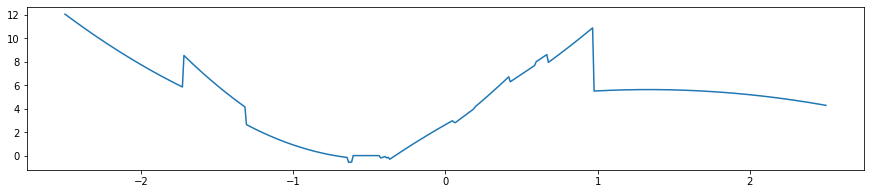

In [101]:
# let's plot dlogit_dbeta
import matplotlib.pyplot as plt

xs = np.linspace(-2.5, 2.5, 500)
ys = np.array([float(dlogit_dbeta.subs(beta, x).simplify()) for x in xs])
plt.figure(figsize=(15, 3))
plt.plot(xs, ys);

# it is discontinuous piecewise-quadratic!

In [102]:
def estimate_upper_bound(expr, param_name, abs_param_bound):
    if type(expr).__name__ == "Add":
        arg_bounds = [estimate_upper_bound(x, param_name, abs_param_bound) for x in expr.args]
        return sum(arg_bounds)
    if type(expr).__name__ == "Mul":
        arg_bounds = [estimate_upper_bound(x, param_name, abs_param_bound) for x in expr.args]
        return np.prod(arg_bounds)
    if type(expr).__name__ == "Float":
        return np.abs(float(expr))
    if type(expr).__name__ == "NegativeOne":
        return 1.0
    if type(expr).__name__ == "Symbol":
        if str(expr) == param_name:
            return abs_param_bound
        else:
            raise RuntimeError(f"Unexpected symbol {expr}")
    if type(expr).__name__ == "Max":
        if len(expr.args) == 2 and str(expr.args[0] == "0"):
            return estimate_upper_bound(expr.args[1], param_name, abs_param_bound)
        else:
            raise RuntimeError(f"Unexpected Max expression {expr}")
    if type(expr).__name__ == "Heaviside":
        return 1.0
    else:
        raise RuntimeError(f"Unexpected type {type(expr)}")

print(estimate_upper_bound(logit, "β", 10))
print(estimate_upper_bound(dlogit_dbeta, "β", 10))

poly_params = [sympy.Function(f"p{i}") for i in range(3)]
p0 = poly_params[0]
p1 = poly_params[1]
p2 = poly_params[2]
poly = 1 - p0(beta)*p1(beta) + 2*p1(beta)*p2(beta)
dpoly_dbeta = poly.diff(beta)
print(dpoly_dbeta)

# TODO
#  compute a pool of bounds
#  construct kappa
#  substitute ps with functions
#  get symbolic derivative
#  recursive estimation for the symbolic derivative
#    see Derivative(p_i) -> subsitute the bound
#    see just p_i -> subsitute with the bound

# if necessary, take the second derivative?

16611.524708540073
4664.706191742972
-p0(β)*Derivative(p1(β), β) - p1(β)*Derivative(p0(β), β) + 2*p1(β)*Derivative(p2(β), β) + 2*p2(β)*Derivative(p1(β), β)


In [103]:
## Let's upper- and lower- bound the derivative with a solver

class sigmoid(sympy.Function):
    @classmethod
    def eval(cls, x):
        return (sympy.functions.elementary.hyperbolic.tanh(2 * x) + 1) / 2

    def _eval_is_real(self):
        return True

smoothing_alpha = 0.01
    
full_poly = 1 - ((1 - smoothing_alpha)*sigmoid(logit) + smoothing_alpha/2)
#print(full_poly)

In [104]:
# see what the expressions become without ReLU and Heaviside

def simplify(expr):
    if type(expr).__name__ == "Add":
        return sum([simplify(x) for x in expr.args])
    if type(expr).__name__ == "Mul":
        result = expr.args[0]
        for x in expr.args:
            result *= simplify(x)
        return result
    if type(expr).__name__ in ["Float", "NegativeOne", "Symbol"]:
        return expr
        if str(expr) == param_name:
            return param
        else:
            raise RuntimeError(f"Unexpected symbol {expr}")
    if type(expr).__name__ == "Max":
        if len(expr.args) == 2 and str(expr.args[0] == "0"):
            return simplify(expr.args[1])
        else:
            raise RuntimeError(f"Unexpected Max expression {expr}")
    if type(expr).__name__ == "Heaviside":
        return simplify(expr.args[0])
    else:
        raise RuntimeError(f"Unexpected type {type(expr)}")

print(expr_to_string(simplify(dlogit_dbeta).simplify()))

-672.14*β**7 - 349.41*β**6 + 1317.78*β**5 + 3890.68*β**4 + 2340.08*β**3 - 98.16*β**2 + 64.52*β - 6.12


In [105]:
def get_bottom_decision_points(expr, param) -> set:
    if type(expr).__name__ == "Heaviside":
        s = str(expr.args[0])
        if "Max(" not in s and "Heaviside(" not in s:
            solutions = sympy.solve(expr.args[0], param)
            assert len(solutions) == 1
            #print(expr, solutions)
            return {solutions[0]}
        return get_bottom_decision_points(expr.args[0], param)
    if type(expr).__name__ == "Max":
        return get_bottom_decision_points(sympy.Heaviside(expr.args[1]), param)
    return set().union(*[get_bottom_decision_points(arg, param) for arg in expr.args])

def to_intervals(points):
    return list(zip(points, points[1:]))

intervals = to_intervals([-np.infty] + sorted(list(get_bottom_decision_points(dlogit_dbeta, beta))) + [np.infty])
print(intervals)

[(-inf, -0.612470856425812), (-0.612470856425812, -0.432663231980555), (-0.432663231980555, -0.386488234621100), (-0.386488234621100, 0.193978320651293), (0.193978320651293, 0.595349248851640), (0.595349248851640, 0.972118908464408), (0.972118908464408, inf)]


In [106]:
def get_subs_value(interval):
    if interval[0] == -np.infty:
        return interval[1] - 1
    if interval[1] == np.infty:
        return interval[0] + 1
    return (interval[1] - interval[0]) / 2
    
def resolve_bottom_decisions(expr, param, param_point):
    if type(expr).__name__ in ["Float", "Integer", "NegativeOne", "Symbol"]:
        return expr
    if type(expr).__name__ in ["Heaviside", "Max"]:
        s = str(expr.args)
        if "Max(" not in s and "Heaviside(" not in s:
            substituted = expr.subs(param, param_point).simplify()
            value = float(substituted)
            #print(f"{expr} in point {param_point} is {value} ~ {sympy.solve(expr.args[0], param)}")
            return value
    return type(expr)(*[resolve_bottom_decisions(arg, param, param_point) for arg in expr.args])

for interval in intervals:
    print(interval)
    e = resolve_bottom_decisions(dlogit_dbeta, beta, get_subs_value(interval)).simplify()
    final_decision_points = get_bottom_decision_points(e, beta)
    final_decision_points = [p for p in final_decision_points if interval[0] < p < interval[1]]
    final_decision_points = [interval[0]] + final_decision_points + [interval[1]]
    # TODO combine
    #points = [-np.infty] + sorted(list(get_bottom_decision_points(dlogit_dbeta, beta))) + [np.infty]
    refined_intervals = to_intervals(final_decision_points)
    for refined_interval in refined_intervals:
        refined_e = resolve_bottom_decisions(e, beta, get_subs_value(refined_interval)).simplify()
        print(" ", refined_interval)
        print("   ", expr_to_string(refined_e))
        print("    additional points:", [x for x in sympy.solve(refined_e, beta)
                                         if refined_interval[0] < x < refined_interval[1]])

(-inf, -0.612470856425812)
  (-inf, -6.15063449207287)
    1.42*β**2 - 1.18*β + 9.82
    additional points: []
  (-6.15063449207287, -0.612470856425812)
    -0.81*β**2 + 2.19*β + 1.36
    additional points: []
(-0.612470856425812, -0.432663231980555)
  (-0.612470856425812, -0.475034624899138)
    -0.02*β**2 + 4.83*β + 2.62
    additional points: [-0.540695295554472]
  (-0.475034624899138, -0.432663231980555)
    1.35*β**2 + 5.77*β + 2.76
    additional points: []
(-0.432663231980555, -0.386488234621100)
  (-0.432663231980555, -0.386488234621100)
    -0.62*β**2 + 3.67*β + 2.72
    additional points: []
(-0.386488234621100, 0.193978320651293)
  (-0.386488234621100, -0.276051778898845)
    1.88*β**2 + 5.06*β + 3.48
    additional points: []
  (-0.276051778898845, -0.253269895906655)
    1.88*β**2 + 5.06*β + 3.44
    additional points: []
  (-0.253269895906655, -0.385928934965550)
    1.88*β**2 + 5.06*β + 3.37
    additional points: []
  (-0.385928934965550, 0.172689782835471)
    1.08*β**